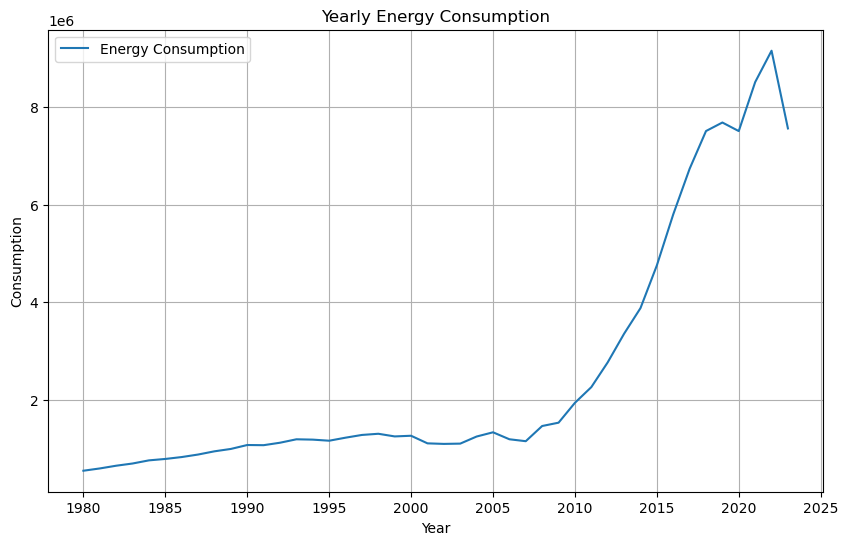

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = "Petrol CSV w Date.csv"
data = pd.read_csv(file_path)

# Rename columns for clarity
data = data.rename(columns={"date": "ds", "consumption": "y"})

# Convert 'ds' to datetime format
data["ds"] = pd.to_datetime(data["ds"], format='%Y')

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(data["ds"], data["y"], label="Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.title("Yearly Energy Consumption")
plt.legend()
plt.grid()
plt.show()

# Normalize the 'y' values for RNN input
scaler = MinMaxScaler(feature_range=(0, 1))
data["y_scaled"] = scaler.fit_transform(data["y"].values.reshape(-1, 1))


In [2]:
pip install pandas


  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 5
X, y = create_sequences(data["y_scaled"].values, sequence_length)

# Split into train and test
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Define the RNN model
model = Sequential([
    SimpleRNN(50, activation="relu", input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(50, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, verbose=1)


Epoch 1/100
2/2 [==============================] - 5s 805ms/step - loss: 0.0287 - val_loss: 0.6580
Epoch 2/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0248 - val_loss: 0.5352
Epoch 3/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0162 - val_loss: 0.4264
Epoch 4/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0104 - val_loss: 0.3313
Epoch 5/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0083 - val_loss: 0.2473
Epoch 6/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0061 - val_loss: 0.1719
Epoch 7/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0091 - val_loss: 0.1148
Epoch 8/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0077 - val_loss: 0.0789
Epoch 9/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0059 - val_loss: 0.0631
Epoch 10/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0056 - val_loss: 0.0559
Epoch 11/100
2/2 [

In [6]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # Inverse scale predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse scale true values

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"R²: {r2}")


1/1 [==============================] - 1s 585ms/step
MAE: 1632779.20525
MAPE: 20.823332880304086%
R²: -3.891559621010745


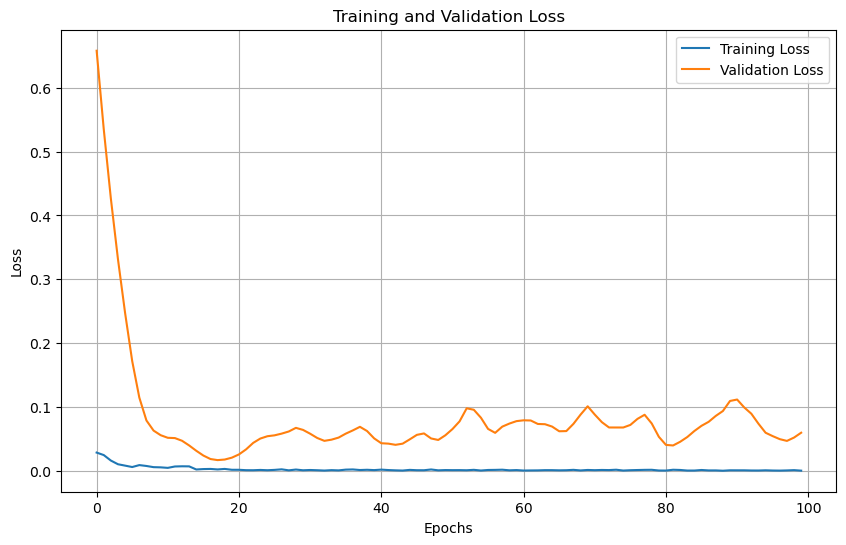

In [7]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()


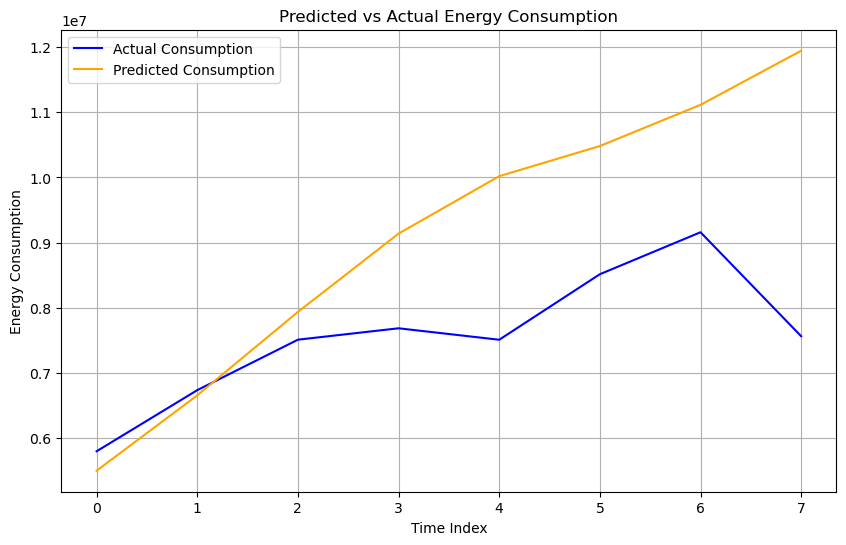

In [8]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual Consumption", color="blue")
plt.plot(range(len(y_pred)), y_pred, label="Predicted Consumption", color="orange")
plt.xlabel("Time Index")
plt.ylabel("Energy Consumption")
plt.title("Predicted vs Actual Energy Consumption")
plt.legend()
plt.grid()
plt.show()


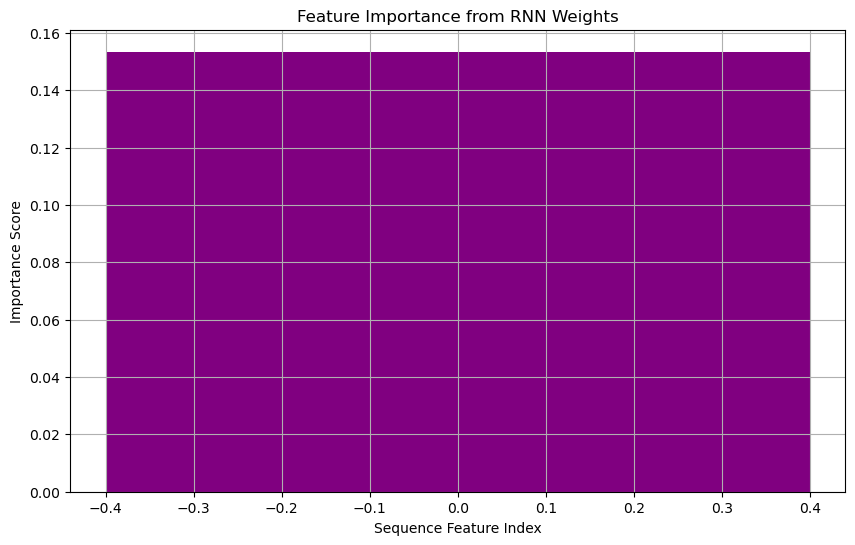

In [9]:
# Simulate feature importance using first-layer weights
weights = model.layers[0].get_weights()[0]
importance = np.mean(np.abs(weights), axis=1)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance, color="purple")
plt.xlabel("Sequence Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance from RNN Weights")
plt.grid()
plt.show()


In [10]:
# Forecast future values (10 years ahead)
future_steps = 10
last_sequence = data["y_scaled"].values[-sequence_length:]

forecast = []
for _ in range(future_steps):
    input_seq = last_sequence.reshape((1, sequence_length, 1))
    pred = model.predict(input_seq)
    forecast.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred[0, 0])

# Inverse scale the forecast
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Add to the dataset
future_years = pd.date_range(start=data["ds"].iloc[-1] + pd.DateOffset(years=1), periods=future_steps, freq="Y")
forecast_df = pd.DataFrame({"ds": future_years, "Forecast": forecast.flatten()})

print(forecast_df)


1/1 [==============================] - 0s 30ms/step
          ds    Forecast
0 2024-12-31  11798589.0
1 2025-12-31  13144541.0
2 2026-12-31  15281026.0
3 2027-12-31  18245168.0
4 2028-12-31  20909228.0
5 2029-12-31  24893262.0
6 2030-12-31  29075966.0
7 2031-12-31  34002680.0
8 2032-12-31  39894288.0
9 2033-12-31  46604132.0


C:\Users\MoaviaHassan\AppData\Local\Temp\ipykernel_12228\518614982.py:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start=data["ds"].iloc[-1] + pd.DateOffset(years=1), periods=future_steps, freq="Y")


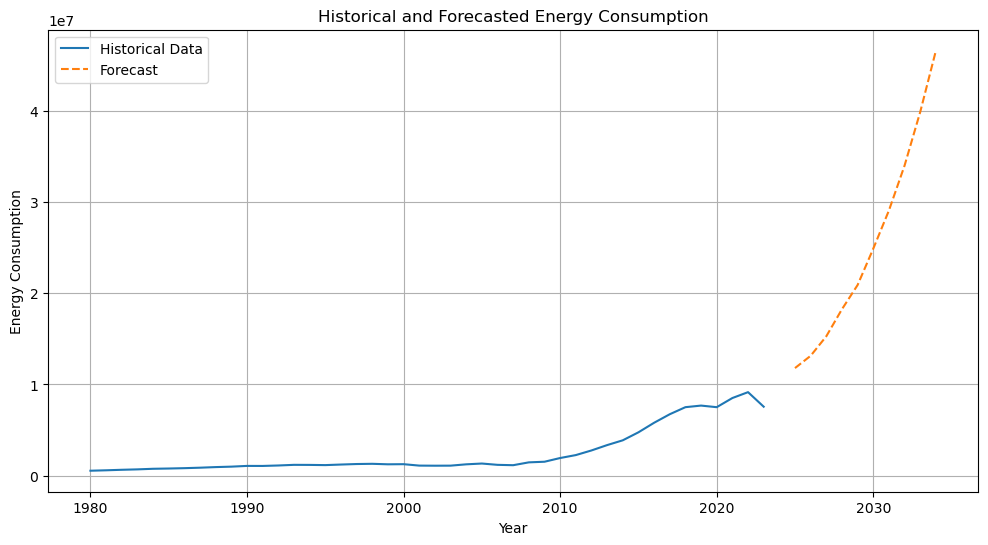

In [11]:
# Combine past and forecast data
plt.figure(figsize=(12, 6))
plt.plot(data["ds"], data["y"], label="Historical Data")
plt.plot(forecast_df["ds"], forecast_df["Forecast"], label="Forecast", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Energy Consumption")
plt.title("Historical and Forecasted Energy Consumption")
plt.legend()
plt.grid()
plt.show()
